# Implementing a simple two layers neural network
In this exercise we will develop a two neural network with fully-connected layers to perform classification, and test it out on the MNIST dataset.

In [3]:
"""
-----------------------------------------------------------------------------
A simple two layers neural network for handwritten digit classification (MNIST)
-----------------------------------------------------------------------------
AUTHOR: Soumitra Samanta (soumitra.samanta@gm.rkmvu.ac.in)
-----------------------------------------------------------------------------
"""

import gzip
import numpy as np
import matplotlib.pyplot as plt

from first_nn_exc import *
# from vis_utils import *

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


# Read MNIST data:
There are many [way](https://stackoverflow.com/questions/40427435/extract-images-from-idx3-ubyte-file-or-gzip-via-python) you can read the MNIST data. Here is a [way](https://stackoverflow.com/a/62781370) to read all the information.

Train data (X) size: (60000, 28, 28), and labels (Y) size: (60000,)
Test data (X) size: (10000, 28, 28), and labels (Y) size: (10000,)


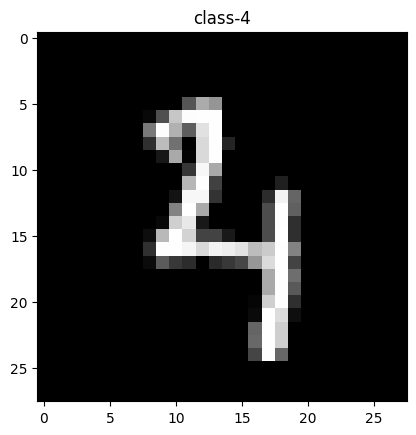

In [8]:
def read_images(filename):
    """Read MNIST images"""
    
    with gzip.open(filename, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8).reshape((image_count, row_count, column_count))
        
    return images

def read_labels(filename):
    """Read MNIST labels"""
    
    with gzip.open(filename, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        
    return labels


dataset_path = ''

train_image_filename = ''.join([dataset_path, 'train-images-idx3-ubyte.gz'])
train_label_filename = ''.join([dataset_path, 'train-labels-idx1-ubyte.gz'])

test_image_filename = ''.join([dataset_path, 't10k-images-idx3-ubyte.gz'])
test_label_filename = ''.join([dataset_path, 't10k-labels-idx1-ubyte.gz'])

train_images = read_images(train_image_filename)
train_labels = read_labels(train_label_filename)

print('Train data (X) size: {}, and labels (Y) size: {}' .format(train_images.shape, train_labels.shape))

test_images = read_images(test_image_filename)
test_labels = read_labels(test_label_filename)

print('Test data (X) size: {}, and labels (Y) size: {}' .format(test_images.shape, test_labels.shape))



rand_ids = np.random.choice(train_images.shape[0])
plt.imshow(train_images[rand_ids, :, :], cmap='gray')
plt.title('class-'+str(train_labels[rand_ids]))
plt.show()



# TODO: Create a validation data from training data (10%) and transform the data in $\mathbf{R}^d$.

In [12]:

from sklearn.model_selection import train_test_split
# Assuming X and Y are your training data and labels
X = train_images  # Example data
Y = train_labels  # Example labels

# Flatten the data
X_flat = X.reshape(60000, -1)

# Initialize lists for train and validation sets
X_train = []
Y_train = []
X_val = []
Y_val = []

# Split data class-wise
for label in np.unique(Y):
    # Get all indices for the current label
    indices = np.where(Y == label)[0]
    X_class = X_flat[indices]
    Y_class = Y[indices]
    
    # Split class data into train and validation sets
    X_train_class, X_val_class, Y_train_class, Y_val_class = train_test_split(
        X_class, Y_class, test_size=0.1, random_state=42)
    
    # Append to the final lists
    X_train.extend(X_train_class)
    Y_train.extend(Y_train_class)
    X_val.extend(X_val_class)
    Y_val.extend(Y_val_class)

# Convert lists to numpy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val = np.array(X_val)
Y_val = np.array(Y_val)

# Assuming test data is given
X_test = test_images  # Example data
Y_test = test_labels  # Example labels

# Flatten test data
X_test = X_test.reshape(10000, -1)

# Print the shapes of the final datasets
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


print('After reshape\n')
print('Train data (X) size: {}, and labels (Y) size: {}' .format(X_train.shape, Y_train.shape))
print('Val data (X) size: {}, and labels (Y) size: {}' .format(X_val.shape, Y_val.shape))
print('Test data (X) size: {}, and labels (Y) size: {}' .format(X_test.shape, Y_test.shape))



                        
                        

X_train shape: (53994, 784)
Y_train shape: (53994,)
X_val shape: (6006, 784)
Y_val shape: (6006,)
X_test shape: (10000, 784)
Y_test shape: (10000,)
After reshape

Train data (X) size: (53994, 784), and labels (Y) size: (53994,)
Val data (X) size: (6006, 784), and labels (Y) size: (6006,)
Test data (X) size: (10000, 784), and labels (Y) size: (10000,)


# Train a network
To train our network we will use SGD . In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [16]:
input_size = X_train.shape[1]
hidden_size = 50
num_classes = 10
net = FirstNN(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, Y_train, X_val, Y_val,
            num_iters=10000, batch_size=200,
            learning_rate=1e-2, learning_rate_decay=0.95,
            reg=0.0, verbose=True)

# Predict on the train set
train_acc = (net.predict(X_train) == Y_train).mean()
print('Train accuracy: ', train_acc)



(200, 10)
iteration 0 / 10000: loss None
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)
(200, 10)

In [5]:
# Predict on the validation set
val_acc = (net.predict(X_val) == Y_val).mean()
print('Validation accuracy: ', val_acc)

# Predict on the test set
test_acc = (net.predict(X_test) == Y_test).mean()
print('Test accuracy: ', test_acc)

# Plot the loss.

In [2]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

